In [ ]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict
from scipy.stats.stats import pearsonr

In [7]:
df_raw = pd.read_csv('/content/drive/My Drive/DM/customer_supermarket.csv', sep='\t', index_col=0) 

# Turn Sale from object to float
df_raw.Sale = df_raw.Sale.apply(lambda x: float(x.replace(',','.')))

# Turn BastedDate from object to datetime64
df_raw['BasketDate'] = pd.to_datetime(df_raw.BasketDate, format='%d/%m/%y %H:%M')

df_raw.ProdID = df_raw.ProdID.apply(lambda x: x.replace('m','M'))

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         471910 non-null  object        
 1   BasketDate       471910 non-null  datetime64[ns]
 2   Sale             471910 non-null  float64       
 3   CustomerID       406830 non-null  float64       
 4   CustomerCountry  471910 non-null  object        
 5   ProdID           471910 non-null  object        
 6   ProdDescr        471157 non-null  object        
 7   Qta              471910 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.4+ MB


###Data Cleaning (Data Preparation)

In [8]:
#1. BANK CHARGES, S, AMAZONFEE, PADS, B, CRUK
#2. Reso dei prodotti nel giorno che sono stati comprati
#3. togliere entry con cancellazione che non sono cancellazioni
#4. mettere maiuscole alla fine del productID
#5. eliminare entry con sale minori di un centesimo
#6. unire prodotti uguali nello stesso carrello

In [9]:
#1. BANK CHARGES, AMAZONFEE, S, PADS, B, CRUK
df_new = df_raw.copy()
print('Entries before removal: ' + str(len(df_new)))
df_new = df_new[df_new.ProdID != 'BANK CHARGES']
df_new = df_new[df_new.ProdID != 'S']
df_new = df_new[df_new.ProdID != 'AMAZONFEE']
df_new = df_new[df_new.ProdID != 'PADS']
df_new = df_new[df_new.ProdID != 'B']
df_new = df_new[df_new.ProdID != 'CRUK']
print('Entries after removal: ' + str(len(df_new)))

Entries before removal: 471910
Entries after removal: 471820


In [10]:
#2. Reso dei prodotti nel giorno che sono stati comprati
print('Entries before removal: ' + str(len(df_new)))

neg_quantities = df_new[df_new['Qta'] < 0]
pos_quantities = df_new[df_new['Qta'] > 0]
pos_neg_join_result = neg_quantities.set_index(["CustomerID", "ProdID"]).join(pos_quantities.set_index(["CustomerID", "ProdID"]), lsuffix='_neg', rsuffix='_pos', how='left')
filtered_pos_neg_join_result = pos_neg_join_result[pos_neg_join_result["Qta_neg"] >= -1 * pos_neg_join_result["Qta_pos"]]
filtered_pos_neg_join_result = filtered_pos_neg_join_result[filtered_pos_neg_join_result["Sale_pos"] == filtered_pos_neg_join_result["Sale_neg"]]
filtered_pos_neg_join_result["distance_in_time"] = pd.Series(filtered_pos_neg_join_result["BasketDate_neg"] - filtered_pos_neg_join_result["BasketDate_pos"],
                                                     index=filtered_pos_neg_join_result.index)
filtered_pos_neg_join_result = filtered_pos_neg_join_result.sort_values(by="distance_in_time")
filtered_pos_neg_join_result = filtered_pos_neg_join_result[filtered_pos_neg_join_result["distance_in_time"] >= pd.Timedelta(0)]

data_to_be_removed = filtered_pos_neg_join_result.copy()
data_to_be_removed = data_to_be_removed[data_to_be_removed["distance_in_time"] < timedelta(days=1)]
data_to_be_removed = data_to_be_removed.reset_index()

pos_BasketID = data_to_be_removed.BasketID_pos
pos_ProductID = data_to_be_removed.ProdID
pos_Qta = data_to_be_removed.Qta_pos


neg_BasketID = data_to_be_removed.BasketID_neg
neg_ProductID = data_to_be_removed.ProdID
neg_Qta = data_to_be_removed.Qta_neg

for basket,prod,qta in zip(pos_BasketID,pos_ProductID,neg_Qta):
  res = df_new[df_new.BasketID == basket]
  res = res[df_new.ProdID == prod]
  if len(res) > 0:
    if res.iloc[0]['Qta'] == -qta:
      df_new = df_new[(df_new.BasketID != basket) | (df_new.ProdID != prod) | (df_new.Qta != -qta)] 
    else:
      df_new.loc[(df_new['BasketID'] == basket ) & (df_new['ProdID'] == prod), 'Qta'] = res.iloc[0]['Qta'] + qta

for basket,prod in zip(neg_BasketID,neg_ProductID):
  df_new = df_new[(df_new.BasketID != basket) | (df_new.ProdID != prod)] 

print('Entries after removal: ' + str(len(df_new)))

Entries before removal: 471820
Entries after removal: 470219


In [11]:
#3. togliere entry con cancellazione che non sono cancellazioni
print('Entries before removal: ' + str(len(df_new)))
df_new = df_new[(df_new.BasketID.str.startswith('C')) | (~df_new.Qta < 0)]
print('Entries after removal: ' + str(len(df_new)))

Entries before removal: 470219
Entries after removal: 469534


In [12]:
#4. mettere maiuscole alla fine del productID
df_new['ProdID'] = df_new['ProdID'].str.upper()

In [13]:
#5. eliminare entry con sale minori di un centesimo
print('Entries before removal: ' + str(len(df_new)))
df_new = df_new[df_new.Sale >= 0.01]
print('Entries after removal: ' + str(len(df_new)))

Entries before removal: 469534
Entries after removal: 468924


In [14]:
#6. unire prodotti uguali nello stesso carrello
print('Entries before removal: ' + str(len(df_new)))
df_new = df_new.groupby(['BasketID','ProdID','BasketDate','CustomerCountry','Sale','CustomerID','ProdDescr'], dropna=False).Qta.sum().to_frame('Qta').reset_index()
print('Entries after removal: ' + str(len(df_new)))

Entries before removal: 468924
Entries after removal: 458959


In [15]:
print("Difference between before and after all removals: " + str(len(df_raw) - len(df_new)))

Difference between before and after all removals: 12951


In [16]:
def get_df_with_total(df_target):
  df = df_target.copy()
  df['BasketDay'] = df.BasketDate.dt.dayofweek
  df['BasketMonth'] = df.BasketDate.dt.month
  df['BasketWeekOfYear'] = df.BasketDate.dt.isocalendar().week
  df['BasketYear'] = df.BasketDate.dt.year
  df['BasketWeekOfMonth'] = df.BasketDate.apply(lambda d: (d.day-1) // 7 + 1)
  df['Tot'] = df['Qta'] * df['Sale']
  return df

In [17]:
# Augment dataset
df_new = get_df_with_total(df_new.copy())
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458959 entries, 0 to 458958
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   BasketID           458959 non-null  object        
 1   ProdID             458959 non-null  object        
 2   BasketDate         458959 non-null  datetime64[ns]
 3   CustomerCountry    458959 non-null  object        
 4   Sale               458959 non-null  float64       
 5   CustomerID         395194 non-null  float64       
 6   ProdDescr          458959 non-null  object        
 7   Qta                458959 non-null  int64         
 8   BasketDay          458959 non-null  int64         
 9   BasketMonth        458959 non-null  int64         
 10  BasketWeekOfYear   458959 non-null  UInt32        
 11  BasketYear         458959 non-null  int64         
 12  BasketWeekOfMonth  458959 non-null  int64         
 13  Tot                458959 non-null  float64 

In [18]:
#df_new.to_csv('/content/drive/MyDrive/DM/Data_Preparation/customer_supermarket_cleaned.csv', index = False, header=True,sep='\t')

In [19]:
# Select only orders
df_new_orders = df_new[df_new["Qta"] > 0] 
df_new_orders = df_new_orders[~df_new_orders["BasketID"].str.startswith("C")]
df_new_orders = df_new_orders[df_new_orders.ProdID.str.match('[0-9]+[a-z]?')]
print("Cardinality of orders subset: %d/%d" % (len(df_new_orders), len(df_new)))
df_new_orders.describe()

Cardinality of orders subset: 448984/458959


,Sale,CustomerID,Qta,BasketDay,BasketMonth,BasketWeekOfYear,BasketYear,BasketWeekOfMonth,Tot
count,448984.000000,385722.000000,448984.000000,448984.000000,448984.000000,448984.000000,448984.000000,448984.000000,448984.000000
mean,3.102738,15289.975760,11.526155,2.502931,7.562327,30.762265,2010.927641,2.593012,20.464964
std,4.337640,1710.703251,40.448783,1.879806,3.468040,14.974818,0.259082,1.252241,89.197494
min,0.040000,12347.000000,1.000000,0.000000,1.000000,1.000000,2010.000000,1.000000,0.060000
25%,1.250000,13969.000000,2.000000,1.000000,5.000000,18.000000,2011.000000,1.000000,4.200000
50%,2.080000,15152.000000,4.000000,2.000000,8.000000,34.000000,2011.000000,3.000000,10.400000
75%,3.750000,16791.000000,12.000000,4.000000,11.000000,44.000000,2011.000000,4.000000,17.850000
max,649.500000,18287.000000,4800.000000,6.000000,12.000000,51.000000,2011.000000,5.000000,38970.000000


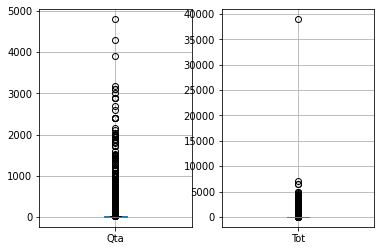

In [ ]:
# Show boxplots for 'Tot' and 'Qta'
fig, (ax1,ax2) = plt.subplots(1, 2)
df_new_orders.boxplot(column='Qta', ax=ax1)
df_new_orders.boxplot(column='Tot', ax=ax2)
plt.savefig("./Qta_Tot_pre.png")
#plt.savefig("/content/drive/MyDrive/DM/Data_Preparation/Plots/Qta_Tot_pre.png")

In [20]:
# Delete outliers basing on inter-quartile distance
print('Entries before removal: ' + str(len(df_new_orders)))
df_new_orders = df_new_orders[(df_new_orders.Tot < 40) & (df_new_orders.Qta < 30)]
print('Entries after removal: ' + str(len(df_new_orders)))

Entries before removal: 448984
Entries after removal: 405715


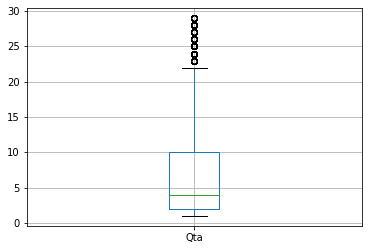

In [23]:
# Show boxplots for 'Tot' and 'Qta'
fig, (ax1) = plt.subplots(1, 1)
df_new_orders.boxplot(column='Tot', ax=ax1)
df_new_orders.boxplot(column='Qta', ax=ax2)
plt.savefig("./Qta_Tot_post.png")
#plt.savefig("/content/drive/MyDrive/DM/Data_Preparation/Plots/Qta_post.png")

In [ ]:
# Save dataset after outlier analysis
#df_new_orders.to_csv('/content/drive/MyDrive/DM/Data_Preparation/customer_supermarket_cleaned_orders.csv', index = False, header=True,sep='\t')

# Outliers

In [ ]:
def basketId_numbers_per_period(df, groupby_period, xlabel):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (14, 5))
  res = df.copy().groupby([groupby_period, "BasketWeekOfYear", "BasketYear"]).BasketID.nunique().reset_index()
  res = res.groupby([groupby_period]).BasketID.mean()
  res.plot.bar(ax=ax1)
  ax1.set_xlabel(xlabel)
  ax1.set_ylabel("Mean")

  res = df.copy().groupby([groupby_period, "BasketWeekOfYear", "BasketYear"]).BasketID.nunique().reset_index()
  res = res.groupby([groupby_period]).BasketID.std()
  res.plot.bar(ax=ax2)
  ax2.set_xlabel(xlabel)
  ax2.set_ylabel('Standard deviation') 

  res = df.copy().groupby([groupby_period]).BasketID.nunique()
  res.plot.bar(ax=ax3)
  ax3.set_xlabel(xlabel)
  ax3.set_ylabel("Count")
  
  return fig

def basketId_numbers_per_day_of_week(df, path):
  fig = basketId_numbers_per_period(df, "BasketDay", "Day of week")
  print("# Basket per day of week")

  plt.tight_layout()
  plt.savefig(path + 'basketId_numbers_per_day_of_week.svg')

def basketId_numbers_per_week_of_month(df, path):
  fig = basketId_numbers_per_period(df, "BasketWeekOfMonth", "Week of month")
  print("# Basket per week of month")

  plt.tight_layout()
  plt.savefig(path + 'basketId_numbers_per_week_of_month.svg')

In [ ]:
df_new_plot = get_df_with_total(df_new_orders)

# Basket per day of week


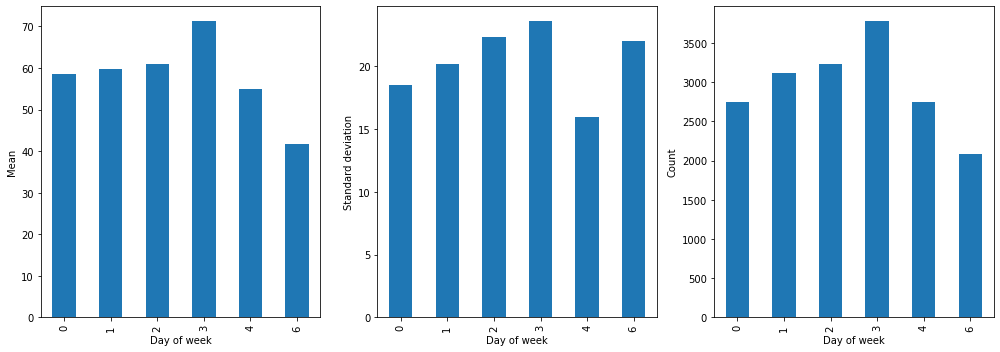

In [ ]:
basketId_numbers_per_day_of_week(df_new_plot, './') #"/content/drive/MyDrive/DM/Data_Preparation/Plots/clean_plots/")

# Basket per week of month


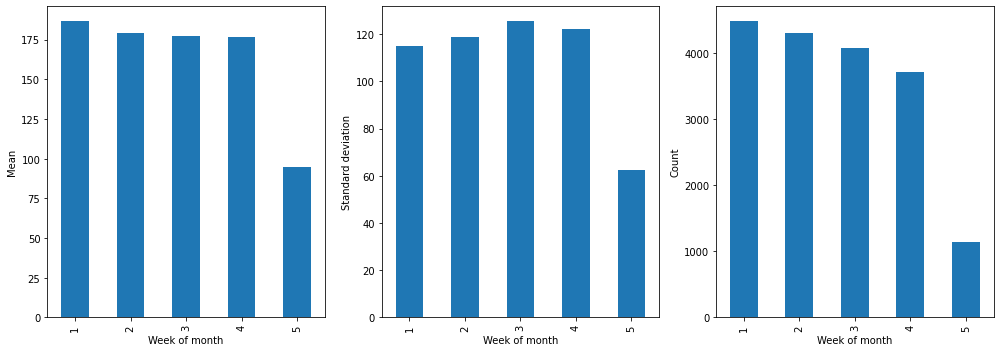

In [ ]:
basketId_numbers_per_week_of_month(df_new_plot, './')#"/content/drive/MyDrive/DM/Data_Preparation/Plots/clean_plots/")

In [ ]:
def distribution_for_period(df, by, value, bins):
  df_plot = df.copy()
  df_plot = df_plot[df_plot[by] == value].groupby(["BasketWeekOfYear", "BasketYear"]).BasketID.nunique().reset_index()
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5))
  boxplot = df_plot.boxplot(column="BasketID", ax = ax1)
  ax1.set_ylabel("")
  ax1.set_xticklabels("")
  histplot = df_plot.hist(column="BasketID", ax = ax2, bins=bins)
  ax2.set_title("")
  return fig

def distribution_for_day_of_week(df, dayOfWeek, bins = 20):
  return distribution_for_period(df, "BasketDay", dayOfWeek, bins)

def distribution_for_week_of_month(df, basketWeekOfMonth, bins = 20):
  return distribution_for_period(df, "BasketWeekOfMonth", basketWeekOfMonth, bins)

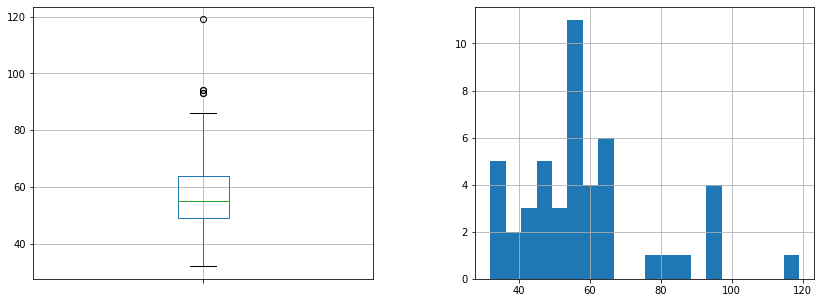

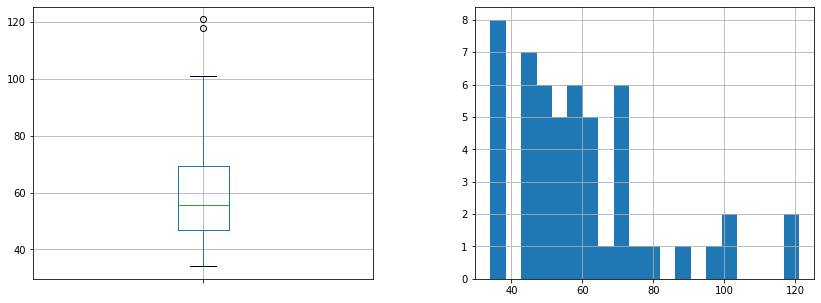

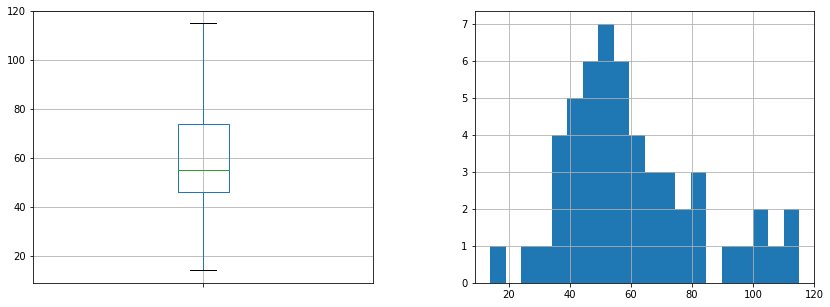

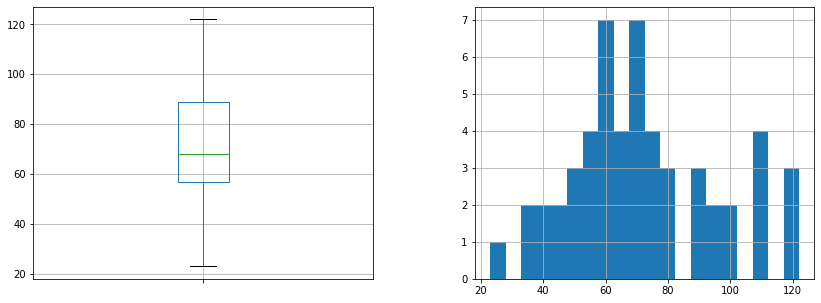

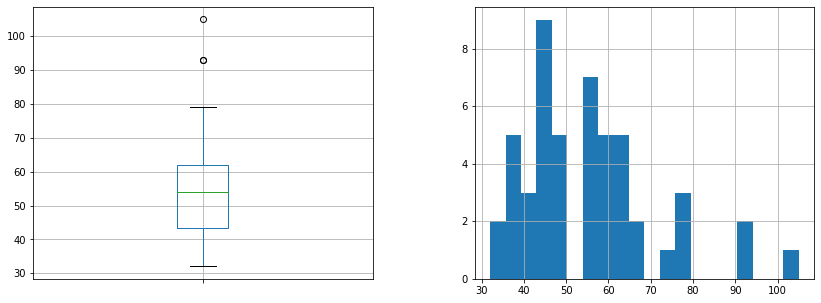

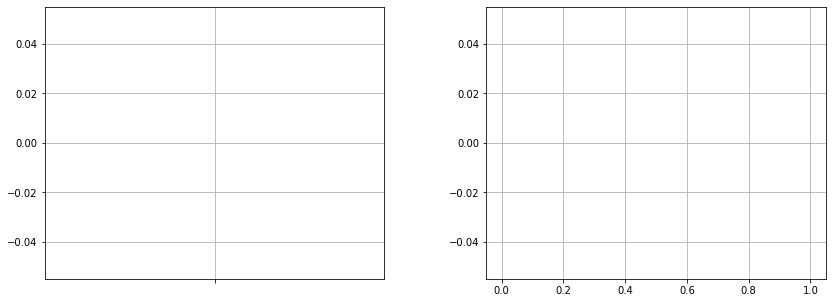

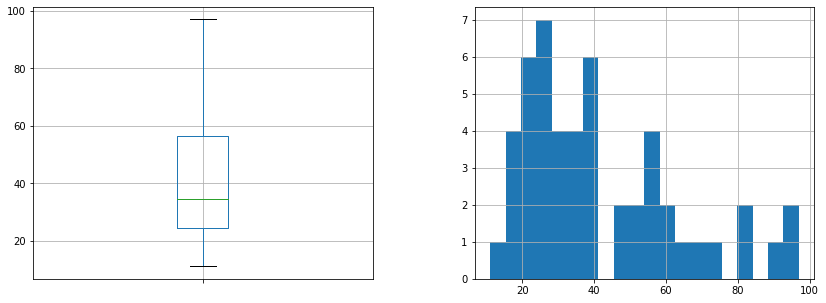

In [ ]:
for i in range(7):
  fig = distribution_for_day_of_week(df_new_plot, i, bins=20)
  plt.savefig("./basketId_numbers-" + str(i+1) + "th-day-of-week-distribution.svg")
  #plt.savefig("/content/drive/MyDrive/DM/Data_Preparation/Plots/clean_plots/basketId_numbers-" + str(i+1) + "th-day-of-week-distribution.svg")

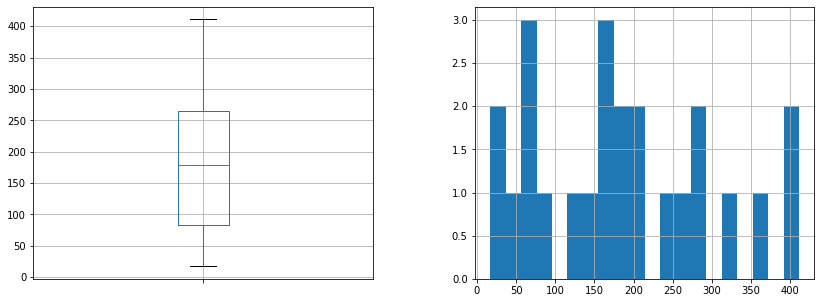

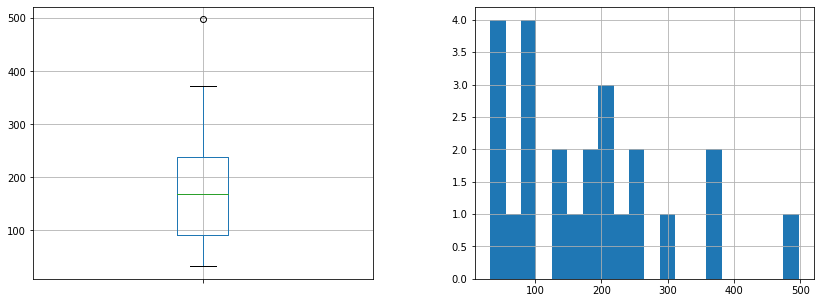

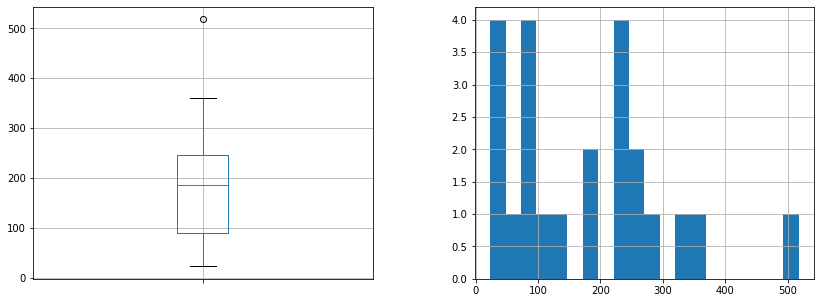

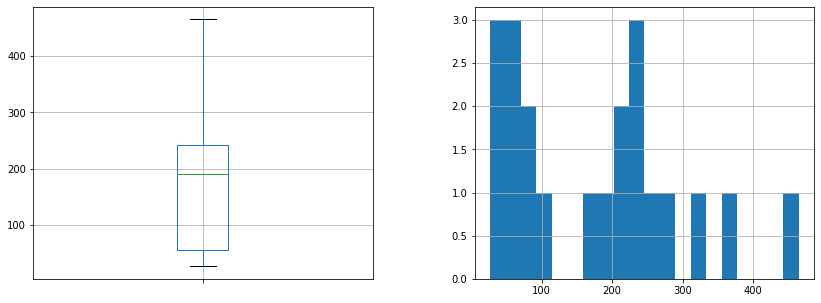

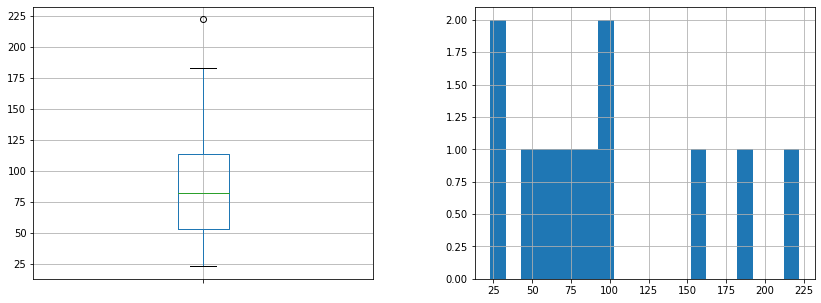

In [ ]:
for i in range(1,6):
  fig = distribution_for_week_of_month(df_new_plot, i, bins=20)
  plt.savefig("./basketId_numbers-" + str(i) + "th-week-of-month-distribution.svg")
  #plt.savefig("/content/drive/MyDrive/DM/Data_Preparation/Plots/clean_plots/basketId_numbers-" + str(i) + "th-week-of-month-distribution.svg")

In [ ]:
def totals_spent_per_period(df, groupby_period, xlabel):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (14, 5))
  res = df.copy().groupby([groupby_period, "BasketWeekOfYear", "BasketYear"]).Tot.sum().reset_index()
  res = res.groupby([groupby_period]).Tot.mean()
  res.plot.bar(ax=ax1)
  ax1.set_xlabel(xlabel)
  ax1.set_ylabel("Mean")

  res = df.copy().groupby([groupby_period, "BasketWeekOfYear", "BasketYear"]).Tot.sum().reset_index()
  res = res.groupby([groupby_period]).Tot.std()
  res.plot.bar(ax=ax2)
  ax2.set_xlabel(xlabel)
  ax2.set_ylabel('Standard deviation') 

  res = df.copy().groupby([groupby_period]).Tot.sum()
  res.plot.bar(ax=ax3)
  ax3.set_xlabel(xlabel)
  ax3.set_ylabel("Sum")
  
  return fig

def totals_spent_per_day_of_week(df, path):
  fig = totals_spent_per_period(df, "BasketDay", "Day of week")
  print("Baskets total per day of week")

  plt.tight_layout()
  plt.savefig(path + 'totals_spent_per_day_of_week.svg')

def totals_spent_per_week_of_month(df, path):
  fig = totals_spent_per_period(df, "BasketWeekOfMonth", "Week of month")
  print("Basket total per week of month")

  plt.tight_layout()
  plt.savefig(path + 'totals_spent_per_week_of_month.svg')

Baskets total per day of week


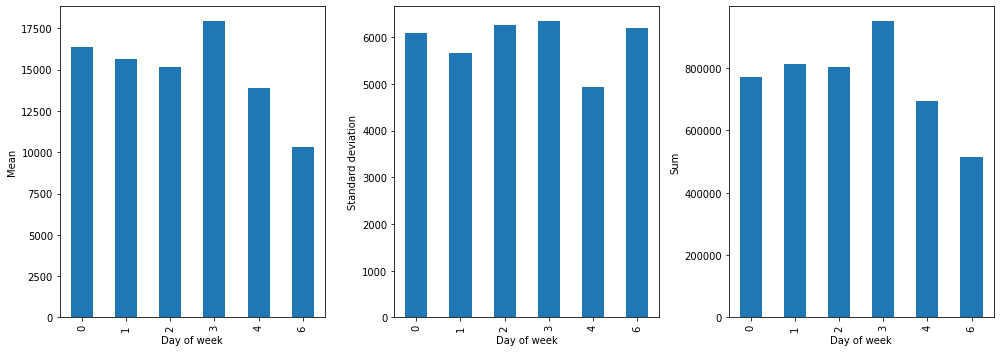

In [ ]:
totals_spent_per_day_of_week(df_new_plot.copy(), './')#"/content/drive/MyDrive/DM/Data_Preparation/Plots/clean_plots/")

Basket total per week of month


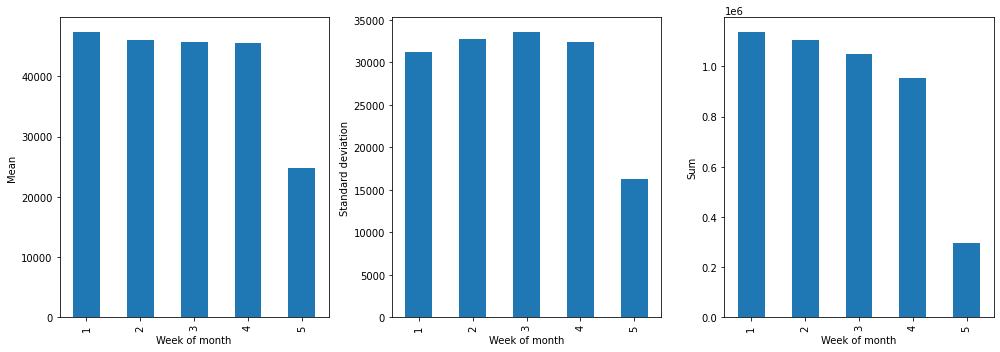

In [ ]:
totals_spent_per_week_of_month(df_new_plot.copy(), './') #"/content/drive/MyDrive/DM/Data_Preparation/Plots/clean_plots/")

In [ ]:
def spent_distribution_for_period(df, by, value, bins):
  df_plot = df.copy()
  df_plot = df_plot[df_plot[by] == value].groupby(["BasketWeekOfYear", "BasketYear"]).Tot.sum().reset_index()
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5))
  boxplot = df_plot.boxplot(column="Tot", ax = ax1)
  ax1.set_ylabel("")
  ax1.set_xticklabels("")
  histplot = df_plot.hist(column="Tot", ax = ax2, bins=bins)
  ax2.set_title("")
  return fig

def spent_distribution_for_day_of_week(df, dayOfWeek, bins = 20):
  return spent_distribution_for_period(df, "BasketDay", dayOfWeek, bins)

def spent_distribution_for_week_of_month(df, basketWeekOfMonth, bins = 20):
  return spent_distribution_for_period(df, "BasketWeekOfMonth", basketWeekOfMonth, bins)

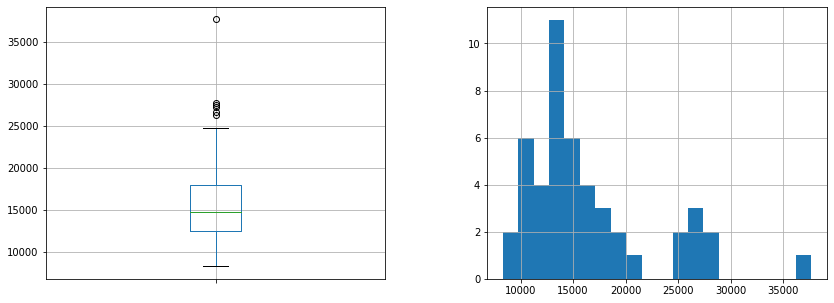

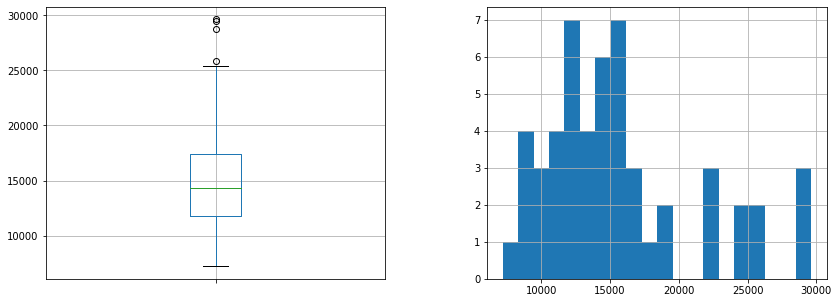

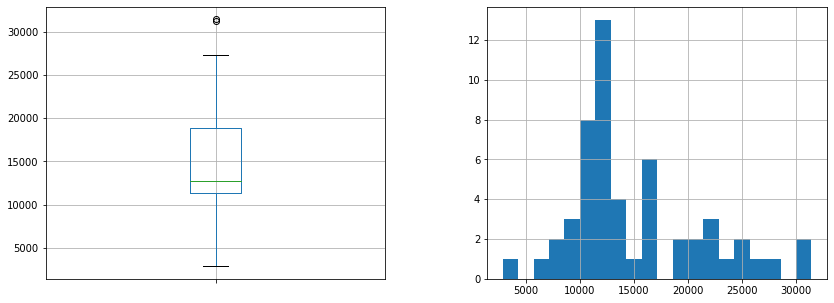

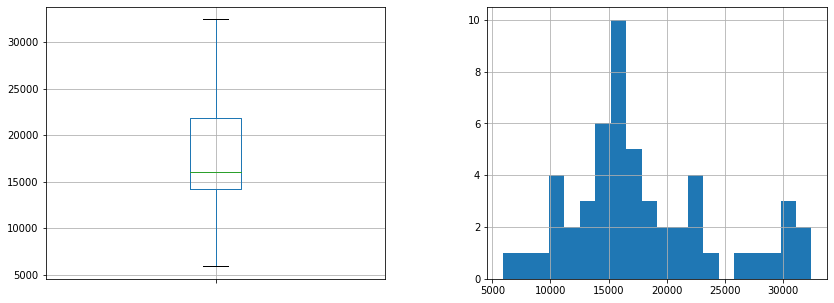

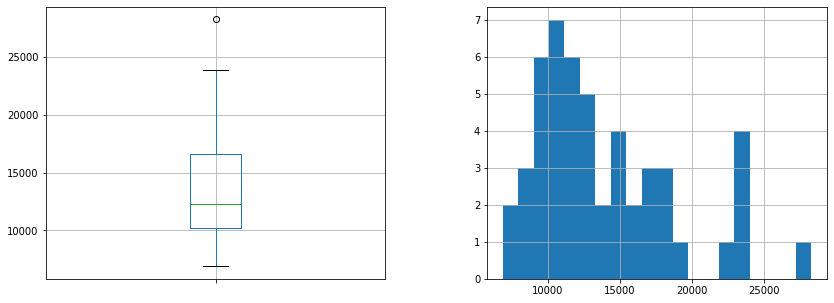

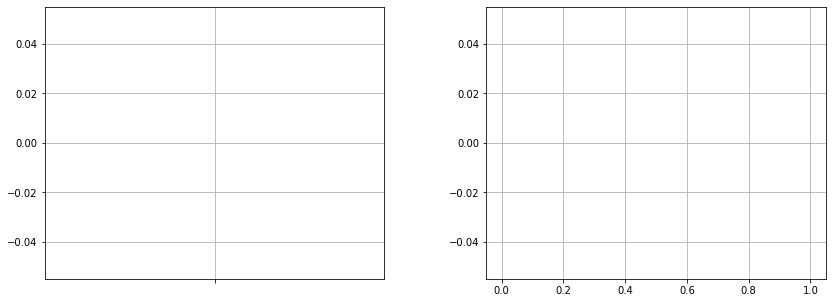

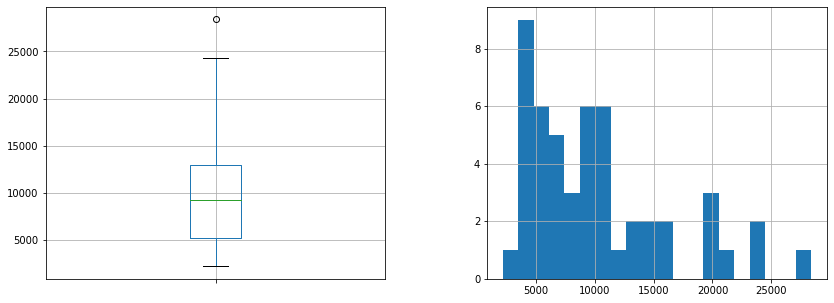

In [ ]:
for i in range(7):
  fig = spent_distribution_for_day_of_week(df_new_plot, i, bins=20)
  plt.savefig("./total_spent-" + str(i+1) + "th-day-of-week-distribution.svg")
  #plt.savefig("/content/drive/MyDrive/DM/Data_Preparation/Plots/clean_plots/total_spent-" + str(i+1) + "th-day-of-week-distribution.svg")

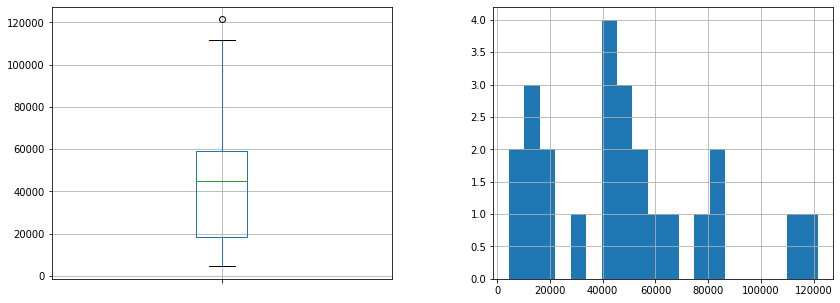

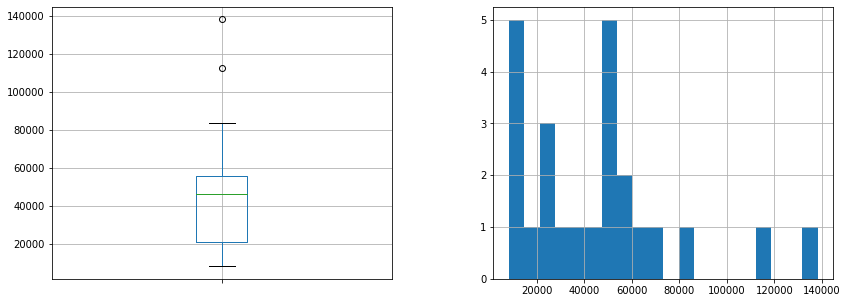

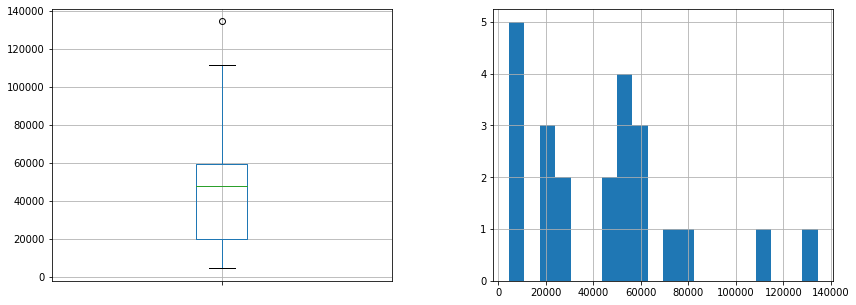

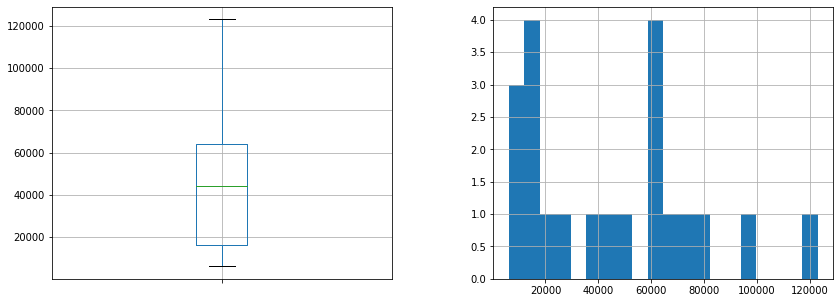

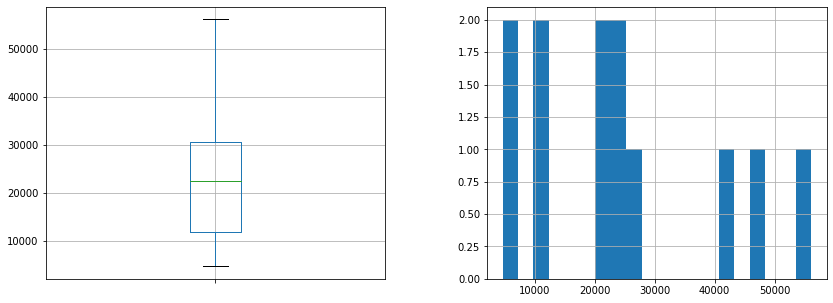

In [ ]:
for i in range(1,6):
  fig = spent_distribution_for_week_of_month(df_new_plot, i, bins=20)
  plt.savefig("./total_spent-" + str(i) + "th-week-of-month-distribution.svg")
  #plt.savefig("/content/drive/MyDrive/DM/Data_Preparation/Plots/clean_plots/total_spent-" + str(i) + "th-week-of-month-distribution.svg")

In [ ]:
def country_distribution(df):
  fig,ax = plt.subplots(2,2,figsize=((15,10)))

  res = df.groupby(['CustomerCountry']).BasketID.nunique()
  ax[0][0].set_title('# Basket')
  ax[0][0].set_ylim(0, 1000)
  res.plot.bar(ax=ax[0][0])

  df_plot = df.groupby(['BasketID','CustomerCountry']).Qta.sum().reset_index()
  res = df_plot.groupby('CustomerCountry').Qta.mean()
  ax[0][1].set_title('Qta mean')
  res.plot.bar(ax=ax[0][1])

  df_plot = df.groupby(['BasketID','CustomerCountry']).Tot.sum().reset_index()
  res = df_plot.groupby('CustomerCountry').Tot.mean()
  ax[1][0].set_title('Tot mean')
  res.plot.bar(ax=ax[1][0])

  df_plot = df.groupby(['BasketID','CustomerCountry']).Tot.sum().reset_index()
  res = df_plot.groupby('CustomerCountry').Tot.sum()
  ax[1][1].set_title('Tot sum')
  ax[1][1].set_ylim(0, 500000)
  res.plot.bar(ax=ax[1][1])

  return fig

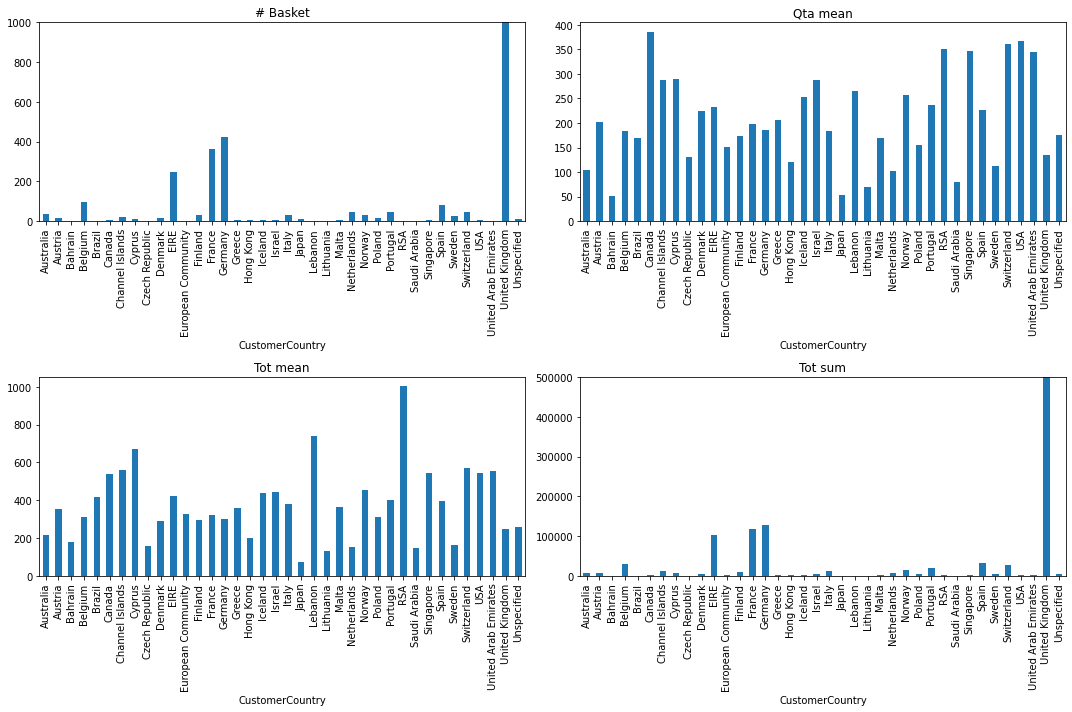

In [ ]:
fig = country_distribution(df_new_plot.copy())
plt.tight_layout()
plt.savefig("./country_distribution.svg")
#plt.savefig("/content/drive/MyDrive/DM/Data_Preparation/Plots/clean_plots/country_distribution.svg")

In [ ]:
def total_price_distribution_among_baskets(df, path):
  df_plot = df.groupby('BasketID').Tot.sum().reset_index()
  df_plot = df_plot[df_plot.Tot <= 1500]
  df_plot = df_plot[df_plot.Tot > 0]
  df_plot.plot.hist(by='Tot',bins=1500, figsize = (16,8))
  plt.gca().set_xlabel('Total price')
  plt.title('Total price distribution')
  plt.savefig(path + "total_price_distribution_among_baskets.svg")

def total_quantity_distribution_among_baskets(df, path):
  df_plot = df.groupby('BasketID').Qta.sum().reset_index()
  df_plot = df_plot[df_plot.Qta <= 1001]
  df_plot = df_plot[df_plot.Qta > 0]

  df_plot.plot.hist(by='Tot',bins=1001, figsize = (16,8))
  plt.gca().set_xlabel('Qta')
  plt.title('Qta distribution')
  plt.savefig(path + "total_quantity_distribution_among_baskets.svg")

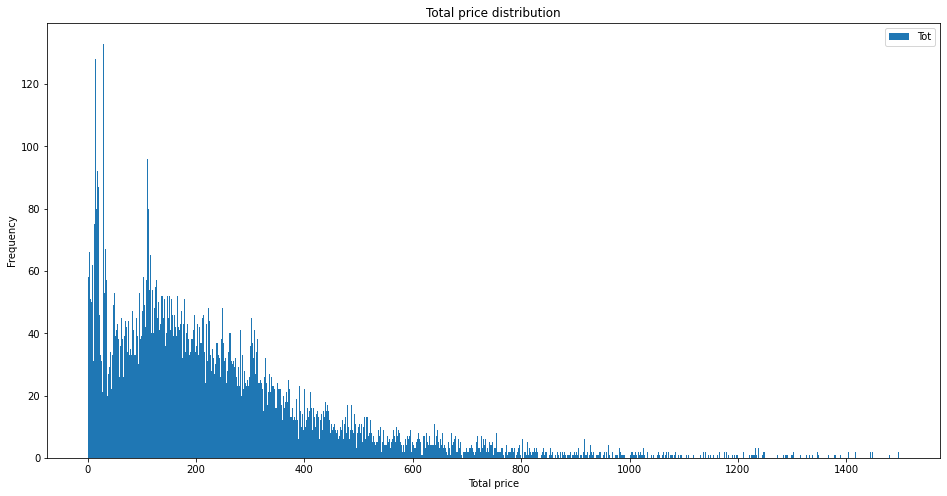

In [ ]:
total_price_distribution_among_baskets(df_new_plot.copy(), './')#"/content/drive/MyDrive/DM/Data_Preparation/Plots/clean_plots/")

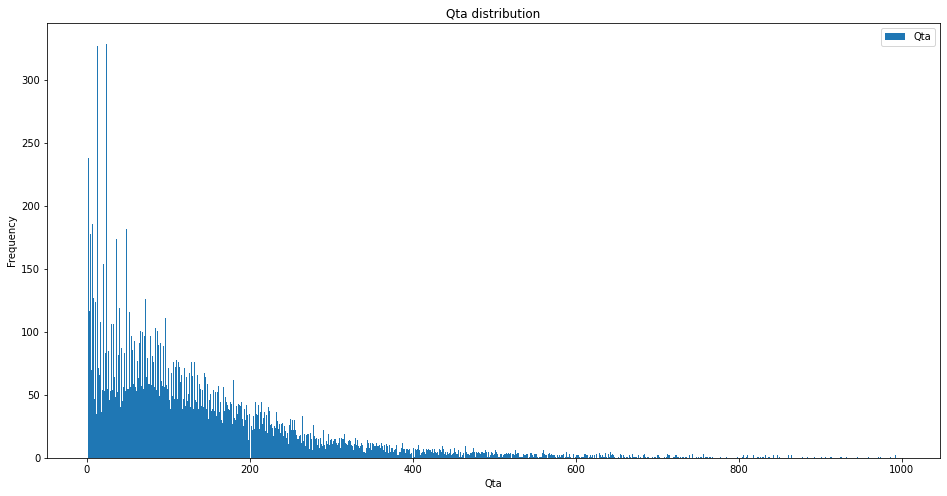

In [ ]:
total_quantity_distribution_among_baskets(df_new_plot.copy(), './')#"/content/drive/MyDrive/DM/Data_Preparation/Plots/clean_plots/")